In [1]:
import numpy as np
import os
import gzip
import platform
import pickle
import struct

</br>

### Fully-connected layer

In [2]:
def fc_fp(z, W, b):
    """ forward propagation of a fully-connected layer
    :param z: output of the previous layer | shape(n,l1)
    :param W: weight of this layer | shape(l1,l2)
    :param b: bias of this layer | shape(l2,)
    :return z_fc: output of this layer | shape(n,l2)
    """
    z_fc = np.dot(z, W) + b
    return z_fc

# # test
# z = [[1,2,3],[1,2,3],[1,2,3]]
# W = [[1,2], [3,4], [5,6]]
# b = [10,20]
# print(fc_fp(z, W, b))

In [3]:
def fc_bp(dz1, W, z):
    """ backward propagation of a fully-connected layer
    :param dz1: gradient of z in next layer | shape(n,l2)
    :param W: weight of this layer | shape(l1,l2)
    :param z: input of this layer | shape(n, l1)
    :return: 
        dW: gradient of weight in this layer | shape(l1,l2)
        db: gradient of bias in this layer | shape(l2,)
        dz: gradient of values in this layer | shape(n,l2)
    """
    n = z.shape[0]
    dW = np.dot(z.T, dz1)/n
    db = np.sum(dz1, axis=0)/n
    dz = np.dot(dz1, W.T)
    return dW, db, dz

### Convolutional layer

In [4]:
def conv2d_fp(z, K, b, padding=(0,0)):
    """ forward propagation of a convolutional layer
    :param z: output of the previous layer | shape(n,c1,h1,w1)
    :param K: kernel of this layer | shape(c1,c2,k1,k2)
    :param b: bias of this layer | shape(c2,)
    :param padding: padding size | shape(p1,p2)
    :return z_conv: output of this layer | shape(n,c2,h2,w2)
    """
    # padding
    p1 = padding[0]
    p2 = padding[1]
    # z_p(n,c1,h1p,w1p)
    z_p = np.lib.pad(z, ((0,0),(0,0),(p1,p1),(p2,p2)), mode='constant', constant_values=0)
    n, c1, h1, w1 = z_p.shape
    c1, c2, k1, k2 = K.shape
    # convolution
    h2 = h1-k1+1
    w2 = w1-k2+1
    z_conv = np.zeros((n, c2, h2, w2))
    for num in range(n):
        for c in range(c2):
            for h in range(h2):
                for w in range(w2):
                    # z_part(1,c1,kernel,kernel)
                    # K_part(c1,1,kernel,kernel)
                    # z_part * K_part(1,1,kernel,kernel)
                    z_part = z_p[num, :, h:h+k1, w:w+k2]
                    K_part = K[:,c]
                    z_conv[num, c, h, w] = np.sum(z_part * K_part) + b[c]
    return z_conv

In [5]:
def conv2d_bp(dz1, K, z, padding=(0,0)):
    """ backward propagation of a 2D-convolutional layer
    :param dz1: gradient of values in the next layer | shape(n,c2,h2,w2)
    :param K: kernel of this layer | shape(c1,c2,k1,k2)
    :param z: values of this layer | shape(n,c1,h1,w1)
    :param padding: padding size | shape(p1,p2)
    :return: 
        dK: gradient of kernel in this layer | shape(c1,c2,k1,k2)
        db: gradient of bias in this layer | shape(c2,)
        dz: gradient of values in this layer | shape(n,c1,h1,w1)
    """
    c1, c2, k1, k2 = K.shape
    n = z.shape[0]
    p1 = padding[0]
    p2 = padding[1]
    
    # z(n,c1,h1,w1) -> z_sw(c1,n,h1,w1) -> z_sw_p(c1,n,h1p,w1p)
    # dz1(n,c2,h2,w2) = (n, c2, h1p-kernel, h2p-kernel)
    # dK: shape(c1,c2,k1,k2)
    z_sw = np.swapaxes(z, 0, 1)
    dK = conv2d_fp(z_sw, dz1, np.zeros((c2,)), (p1, p2))/n
    
    # db: shape(c2,)
    db = np.sum(dz1, axis=(0, 2, 3))/n
    
    # dz1 padding: shape(n, c2, h2+2kernel, w2+2kernel) = (n, c2, h1p+kernel, w1p+kernel)
    # modify K: shape(c1,c2,k1,k2) -> rotation(c1,c2,k1,k2) -> Kr(c2,c1,k1,k2)
    # padded dz: shape(n,c1,h1p,w1p)
    dz1_p = np.lib.pad(dz1, ((0,0), (0,0), (k1-1, k1-1), (k2-1, k2-1)), mode='constant', constant_values=0)
    Kr = np.swapaxes(np.flip(K, (2,3)), 0,1)
    dz_p = conv2d_fp(dz1_p, Kr, np.zeros((c2,)))
    # remove padding of dz_p(n,c1,h1p,w1p) -> dz(n,c1,h1,w1)
    dz = dz_p
    if(p1 > 0 and p2 > 0):
        dz = dz[:, :, p1:-p1, p2:-p2]
    elif p1 > 0:
        dz = dz[:, :, p1:-p1, :]
    elif p2 > 0:
        dz = dz[:, :, :, p2:-p2]
    return dK, db, dz

</br>

### Pooling layer - Max pooling

In [6]:
def maxpool_fp(z, pool_size=(2,2), pool_stride=(2,2), padding=(0,0)):
    """ forward propagation of a max-pooling layer
    :param z: output of the previous layer | shape(n,c1,h1,w1)
    :param pool_size: size of pooling kernel | shape(k1,k2)
    :param pool_stride: stride of pooling kernel | shape(s1,s2)
    :param padding: padding size | shape(p1,p2)
    :return z_po: output of this layer | shape(n,c1,h2,w2)
    """
    n, c1, h1, w1 = z.shape
    k1 = pool_size[0]
    k2 = pool_size[1]
    s1 = pool_stride[0]
    s2 = pool_stride[1]
    p1 = padding[0]
    p2 = padding[1]
    h2 = (h1 + p1*2 - k1)//s1 + 1
    w2 = (w1 + p2*2 - k2)//s2 + 1
    # padding of z
    z_p = np.lib.pad(z, ((0,0), (0,0), (p1, p1), (p2, p2)), 'constant', constant_values=0)
    z_po = np.zeros((n,c1,h2,w2))
    for num in range(n):
        for c in range(c1):
            for h in range(h2):
                for w in range(w2):
                    z_part = z_p[num, c, h*s1:h*s1+k1, w*s2:w*s2+k2]
                    z_po[num,c,h,w] = np.max(z_part)
    return z_po
  
# # test
# z = np.random.randn(10, 2, 6, 6)
# z_po = maxpool_fp(z, padding=(3,3))
# print(z.shape)
# print(z_po.shape)

In [7]:
def maxpool_bp(dz1, z, pool_size=(2,2), pool_stride=(2,2), padding=(0,0)):
    """ backward propagation of a max-pooling layer
    :param dz1: gradient of values in the next layer | shape(n,c1,h2,w2)
    :param z: values of this layer | shape(n,c1,h1,w1)
    :param pool_size: size of pooling kernel | shape(k1,k2)
    :param pool_stride: stride of pooling kernel | shape(s1,s2)
    :param padding: padding size | shape(p1,p2)
    :return dz: gradient of values in this layer | shape(n,c1,h1,w1)
    """
    n, c1, h1, w1 = z.shape
    n, c2, h2, w2 = dz1.shape
    k1 = pool_size[0]
    k2 = pool_size[1]
    s1 = pool_stride[0]
    s2 = pool_stride[1]
    p1 = padding[0]
    p2 = padding[1]
    # padding of z: shape(n,c1,h1p,w1p)
    z_p = np.lib.pad(z, ((0,0), (0,0), (p1, p1), (p2, p2)), 'constant', constant_values=0)
    # padded dz: shape(n,c1,h1p,w1p)
    dz_p = np.zeros(z_p.shape)
    for num in range(n):
        for c in range(c1):
            for h in range(h2):
                for w in range(w2):
                    # associated part in z_p of the element dz1[num, c, h, w]
                    z_part = z_p[num, c, h*s1:h*s1+k1, w*s2:w*s2+k2]
                    # index of max in z_part
                    id_max_z_part = np.argmax(z_part)
                    # index of this max in z_p
                    h_max_z_p = h*s1 + id_max_z_part // k2
                    w_max_z_p = w*s2 + id_max_z_part % k2
                    dz_p[num, c, h_max_z_p, w_max_z_p] += dz1[num, c, h, w]
    # remove padding of dz_p(n,c1,h1p,w1p) -> dz(n,c1,h1,w1)
    dz = dz_p
    if(p1 > 0 and p2 > 0):
        dz = dz[:, :, p1:-p1, p2:-p2]
    elif p1 > 0:
        dz = dz[:, :, p1:-p1, :]
    elif p2 > 0:
        dz = dz[:, :, :, p2:-p2]
    return dz
  
# # test
# z = np.array([[[[1,5,8,6],
#        [2,4,6,4],
#        [3,5,7,3],
#        [5,10,3,5]]]])
# z_po = maxpool_fp(z, pool_size=(2,2), pool_stride=(1,1), padding=(0,0))
# dz1 = z_po/5
# dz = maxpool_bp(dz1, z, pool_size=(2,2), pool_stride=(1,1), padding=(0,0))
# print(z_po)
# print(dz1)
# print(dz)

</br>

### Flatten layer

In [8]:
def flatten_fp(z):
    """ change the dimention of data: 2D to 1D
    :param z: output of previous layer | shape(n,c1,h1,w1)
    :return z_flt: output after flattening | shape(n,l1)
    """
    n = z.shape[0]
    z_flt = np.reshape(z, (n,-1))
    return z_flt
  
# test
# z = np.random.randn(2, 2, 3, 3)
# z_flt = flatten_fp(z)
# print(z.shape)
# print(z_flt.shape)

In [9]:
def flatten_bp(dz1, z):
    """ backward propagation of flatten layer
    :param dz1: gradient of z in next layer | shape(n,l1)
    :param z: output of previous layer | shape(n,c1,h1,w1)
    :return dz: gradient of z in this layer | shape(n,c1,h1,w1)
    """
    dz = np.reshape(dz1, z.shape)
    return dz

# # test
# z = np.random.randn(2, 2, 3, 3)
# dz1 = flatten_fp(z)
# dz = flatten_bp(dz1, z)
# print(z.shape)
# print(dz1.shape)
# print(dz.shape)

</br>

### Activate function

In [10]:
def relu_fp(z):
    """ forward propagation of activate function - Relu
    :param z: output of previous layer | shape(n,l1)
    :return: output after activate layer Relu | shape(n,l1)
    """
    return np.maximum(0, z)


def relu_bp(dz1, z):
    """ backward propagation of activate function - Relu
    :param dz1: gradient of z in next layer | shape(n,l2=l1)
    :param z: output of previous layer | shape(n,l1)
    :return dz: gradient of z in this layer | shape(n,l1)
    """
    dz = np.where(np.greater(z, 0), dz1, 0)
    return dz

In [11]:
def tanh_fp(z):
    """ forward propagation of activate function - tanh
    :param z: output of previous layer
    :return: output after activate layer Relu
    """
    return np.tanh(z)
  

def tanh_bp(dz1):
    """ backward propagation of activate function - tanh
    :param dz1: gradient of z in next layer
    :return dz: gradient of z in this layer
    """
    dz = 1 - np.square(np.tanh(dz1))
    return dz

</br>

### Loss function - mean squared loss, softmax & cross entropy

In [12]:
def mean_squared(y, yr):
    """ loss function - mean squared loss
    :param y: output of the last layer | shape(n,ln)
    :param yr: real value of the samples | shape(n,ln)
    :return:
        loss: total loss | shape(1,)
        dy: gradient of values in this layer | shape(n,ln)
    """
    sq = np.square(y - yr)/2
    loss = np.mean(np.sum(sq, axis=-1))
    dy = y - yr
    return loss, dy
  
# #test 
# y = np.array([[0.1,0.1,0.8],[0.1,0.1,0.8],[0.2,0.2,0.6],[0.01,0.01,0.98]])
# yr = np.array([[0,0,1],[0,0,1],[0,0,1],[0,0,1]])
# loss, dy = mean_squared(y, yr)
# print(loss)
# print(dy)

In [13]:
def softmax(y):
    """ softmax function
    :param y: output of the last layer | shape(n,ln)
    :return: y after softmax | shape(n,ln)
    """
    return (np.exp(y).T/np.sum(np.exp(y), axis=-1)).T
  
# # test
# y = np.array([[1,2,3],[1,2,3],[1,2,5]])
# res = softmax(y)
# print(res)

In [14]:
def cross_entropy(y, yr):
    """ loss function - cross entropy
    :param y: output of the last layer | shape(n,ln)
    :param yr: real value of the samples | shape(n,ln)
    :return: 
        loss: total loss | shape(1,)
        dy: gradient of values in this layer | shape(n,ln)
    """
    sftmx = softmax(y)
    lg = -np.log(sftmx)
    yr_log = yr * lg
    loss = np.mean(np.sum(yr_log, axis=-1))
    dy = sftmx - yr
    return loss, dy
    
# #test 
# y = np.array([[0.1,0.1,0.8],[0.1,0.1,0.8],[0.2,0.2,0.6],[0.01,0.01,0.98]])
# yr = np.array([[0,0,1],[0,0,1],[0,0,1],[0,0,1]])
# loss, dy = corss_entropy(y, yr)
# print(loss)
# print(dy)

</br>

### Optimizer

In [15]:
def sgd(weights, gradients, lr=0.01):
    """ use SGD to optimize parameters in the network
    :param weights: current parameters | dictionnary
    :param gradients: current gradients | dictionnary
    :param lr: learning rate
    """
    for itm in weights.keys():
        weights[itm] = weights[itm] - lr*gradients[itm]

In [16]:
def sgd_md(weights, gradients, v_weights, lr=0.01, it=0, momentum=0.9, decay=1e-5):
    """ use SGD with momentum and decay to optimize parameters in the network
    :param weights: current parameters | dictionnary
    :param gradients: current gradients | dictionnary
    :param v_weights: amount of update of weights | dictionnary
    :param lr: learning rate
    :param momentum: momentum of parameters
    :param decay: decay of learning rate
    :return:
        lr: updated learning rate
        it: number of iteration
    """
    # update leaning rate
    lr = lr / (1 + decay*it)
    # upgrade weights
    for itm in weights.keys():
        v_weights[itm] = momentum * v_weights[itm] + lr*gradients[itm]
        weights[itm] -= v_weights[itm]
    it += 1
    return lr, it

### Load data

In [17]:
# the file of train images
train_images_idx3_ubyte_file = 'train-images.idx3-ubyte'
# the file of train labels
train_labels_idx1_ubyte_file = 'train-labels.idx1-ubyte'

# the file of test images
test_images_idx3_ubyte_file = 't10k-images.idx3-ubyte'
# the file of test labels
test_labels_idx1_ubyte_file = 't10k-labels.idx1-ubyte'


def decode_idx3_ubyte(idx3_ubyte_file):
    """
    decode ''.idx3-ubyte' file
    :param idx3_ubyte_file: the path of '.idx3-ubyte' file
    :return: images | shape(n, rows, cols)
    """
    bin_data = open(idx3_ubyte_file, 'rb').read()

    # decode file header information
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print ('magic number:%d, images number: %d, image size: %d*%d' % (magic_number, num_images, num_rows, num_cols))

    # decode data set
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print ('have decoded %d' % (i + 1) + 'images')
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images


def decode_idx1_ubyte(idx1_ubyte_file):
    """
    decode ''.idx1-ubyte' file
    :param idx1_ubyte_file: the path of '.idx1-ubyte' file
    :return: labels | shape(n, 1)
    """
    bin_data = open(idx1_ubyte_file, 'rb').read()

    # decode file header information
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    print ('magic number:%d, images number: %d' % (magic_number, num_images))

    # decode data set
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print ('have decoded %d' % (i + 1) + 'images')
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels


def load_train_images(idx_ubyte_file=train_images_idx3_ubyte_file):
    """
    TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

    :param idx_ubyte_file: the path of train images
    :return: images | shape(n,28,28)
    """
    return decode_idx3_ubyte(idx_ubyte_file)


def load_train_labels(idx_ubyte_file=train_labels_idx1_ubyte_file):
    """
    TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.

    :param idx_ubyte_file: the path of train labels
    :return: labels | shape(n,1)
    """
    return decode_idx1_ubyte(idx_ubyte_file)


def load_test_images(idx_ubyte_file=test_images_idx3_ubyte_file):
    """
    TEST SET IMAGE FILE (t10k-images-idx3-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  10000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

    :param idx_ubyte_file: the path of test images
    :return: images | shape(n,28,28)
    """
    return decode_idx3_ubyte(idx_ubyte_file)


def load_test_labels(idx_ubyte_file=test_labels_idx1_ubyte_file):
    """
    TEST SET LABEL FILE (t10k-labels-idx1-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  10000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.

    :param idx_ubyte_file: the path of test labels
    :return: labels | shape(n,1)
    """
    return decode_idx1_ubyte(idx_ubyte_file)

In [18]:
train_images = load_train_images()
train_labels = load_train_labels()
test_images = load_test_images()
test_labels = load_test_labels()

magic number:2051, images number: 60000, image size: 28*28
have decoded 10000images
have decoded 20000images
have decoded 30000images
have decoded 40000images
have decoded 50000images
have decoded 60000images
magic number:2049, images number: 60000
have decoded 10000images
have decoded 20000images
have decoded 30000images
have decoded 40000images
have decoded 50000images
have decoded 60000images
magic number:2051, images number: 10000, image size: 28*28
have decoded 10000images
magic number:2049, images number: 10000
have decoded 10000images


###  Preprocess data

In [19]:
def to_categorical(y, num_classes=None):
    """
    Converts a class vector (integers) to binary class matrix (one-hot encoding).
    :param y: class vector to be converted into a matrix (integers from 0 to num_classes). | shape(n,1)
    :param num_classes: total number of classes.
    :return categorical: A binary matrix representation of the input. | shape(n,num_classes)
    """
    if num_classes==None:
        num_classes = np.max(y)+1
    # the number of samples
    n = y.shape[0]
    categorical = np.zeros((n,num_classes), dtype=np.float32)
    for i in range(n):
        categorical[i][int(y[i])] = 1
    return categorical

In [20]:
# shuffle the train data set
train_num = train_images.shape[0]
train_random = np.arange(train_num)
np.random.shuffle(train_random)
train_images = train_images[train_random, :]
train_labels = train_labels[train_random]
train_labels = to_categorical(train_labels, num_classes=10)

# shuffle the test data set
test_num = test_images.shape[0]
test_random = np.arange(test_num)
np.random.shuffle(test_random)
test_images = test_images[test_random,:]
test_labels = test_labels[test_random]
test_labels = to_categorical(test_labels, num_classes=10)

# split the validation data set and count the number of each data set
valid_num = int(0.1*train_num)
train_num = train_num-valid_num
valid_images = train_images[:valid_num,:]
valid_labels = train_labels[:valid_num,:]
train_images = train_images[valid_num:,:]
train_labels = train_labels[valid_num:,:]
print("shape of train images:", train_images.shape, "\tshape of train labels:", train_labels.shape)
print("shape of validation images:", valid_images.shape, "\tshape of validation labels:", valid_labels.shape)
print("shape of test imagees:", test_images.shape, "\tshape of test labels:", test_labels.shape)

# preprocess images and reshape image data
train_images = train_images/255
valid_images = valid_images/255
test_images = test_images/255
train_images = train_images.reshape(-1,1,28,28)
valid_images = valid_images.reshape(-1,1,28,28)
test_images = test_images.reshape(-1,1,28,28)

shape of train images: (54000, 28, 28) 	shape of train labels: (54000, 10)
shape of validation images: (6000, 28, 28) 	shape of validation labels: (6000, 10)
shape of test imagees: (10000, 28, 28) 	shape of test labels: (10000, 10)


### Method of evaluation

In [21]:
def accuracy(y_pred, y_true):
    """
    calculate the total accuracy of the data set
    :param y_pred: prediction of the model | shape (n,num_classes)
    :param y_true: true labels of the data set | shape(n,num_classes)
    :return acc: the total accuracy | shape(1,)
    """
    return np.mean(np.equal(np.argmax(y_pred,axis=1), np.argmax(y_true,axis=1)))


def categorical_precision(y_pred, y_true):
    """
    calculate the precision of each category
    :param y_pred: prediction of the model | shape (n,num_classes)
    :param y_true: true labels of the data set | shape(n,num_classes)
    :return acc: the precision of each category | shape(1,cun_classes)
    """
    pred = np.argmax(y_pred, axis=1)
    pred = to_categorical(pred, num_classes=10)
    # count the number of each category in the prediction of the model
    pred_ca_num = np.sum(pred, axis=0)
    true = np.transpose(y_true)
    acc = np.dot(true, pred)
    # count the true numer of each category in the prediction of the model
    true_ca_num = []
    for i in range(10):
        true_ca_num.append(acc[i,i])
    true_ca_num = np.array(true_ca_num)
    return true_ca_num/pred_ca_num

### Save model and load model

In [22]:
def save_model(path):
    """
    save weights, nuerons, and gradients in three files and save other details of the model
    :param path: the folder used to save model
    """
    global lr, epoch, valid_loss, valid_acc, valid_ca_acc
    details = {"lr":lr, "epoch":epoch, "valid_loss":valid_loss, "valid_acc":valid_acc, "valid_ca_prec":valid_ca_prec}
    np.save(os.path.join(path,'weights.npy'), weights) 
    np.save(os.path.join(path,'nuerons.npy'), nuerons) 
    np.save(os.path.join(path,'gradients.npy'), gradients) 
    np.save(os.path.join(path,'details.npy'), details)
    print("saving model to", path, end="\n\n")
    
    
def load_model(path):
    """
    load weights, nuerons, and gradients and other details of the saved model
    :param path: the folder used to load model
    :return: weights, nuerons, gradients, lr, epoch, valid_loss, valid_acc, valid_ca_prec
    """
    weights = np.load(os.path.join(path,'weights.npy'), allow_pickle=True).item()
    nuerons = np.load(os.path.join(path,'nuerons.npy'), allow_pickle=True).item()
    gradients = np.load(os.path.join(path,'gradients.npy'), allow_pickle=True).item()
    details = np.load(os.path.join(path,'details.npy'), allow_pickle=True).item()
    return weights, nuerons, gradients, [details["lr"], details["epoch"], details["valid_loss"], details["valid_acc"], details["valid_ca_prec"]]

### Construct model

In [23]:
weights = {}
nuerons={}
gradients={}

weights_scale = 1e-1
filters = 32
fc_units=64
weights["K1"] = weights_scale * np.random.randn(1, filters, 3, 3).astype(np.float64)
weights["b1"] = np.zeros(filters).astype(np.float64)
weights["K2"] = weights_scale * np.random.randn(filters, filters, 3, 3).astype(np.float64)
weights["b2"] = np.zeros(filters).astype(np.float64)
weights["W3"] = weights_scale * np.random.randn(800, fc_units).astype(np.float64)
weights["b3"] = np.zeros(fc_units).astype(np.float64)
weights["W4"] = weights_scale * np.random.randn(fc_units, 10).astype(np.float64)
weights["b4"] = np.zeros(10).astype(np.float64)



v_weights = {}
for itm in weights.keys():
    v_weights[itm] = np.zeros_like(weights[itm])


# define the total forward propagation
def forward(X):
    nuerons["conv1"]=conv2d_fp(X.astype(np.float64), weights["K1"],weights["b1"])
    nuerons["conv1_relu"]=relu_fp(nuerons["conv1"])
    nuerons["maxp1"]=maxpool_fp(nuerons["conv1_relu"].astype(np.float64))

    nuerons["conv2"]=conv2d_fp(nuerons["maxp1"], weights["K2"], weights["b2"])
    nuerons["conv2_relu"]=relu_fp(nuerons["conv2"].astype(np.float64))
    nuerons["maxp2"]=maxpool_fp(nuerons["conv2_relu"].astype(np.float64))
    
    
    nuerons["flatten"]=flatten_fp(nuerons["maxp2"])

    nuerons["fc2"]=fc_fp(nuerons["flatten"],weights["W3"],weights["b3"])
    nuerons["fc2_relu"]=relu_fp(nuerons["fc2"])

    nuerons["y"]=fc_fp(nuerons["fc2_relu"],weights["W4"],weights["b4"])

    return nuerons["y"]

# define the total backward propagation
def backward(X,y_true):
    loss, dy = cross_entropy(nuerons["y"],y_true)
    gradients["W4"], gradients["b4"], gradients["fc2_relu"] = fc_bp(dy, weights["W4"], nuerons["fc2_relu"])
    gradients["fc2"] = relu_bp(gradients["fc2_relu"], nuerons["fc2"])

    gradients["W3"], gradients["b3"], gradients["flatten"] = fc_bp(gradients["fc2"], weights["W3"], nuerons["flatten"])
        
    gradients["maxp2"] = flatten_bp(gradients["flatten"], nuerons["maxp2"])
    gradients["conv2_relu"] = maxpool_bp(gradients["maxp2"].astype(np.float64), nuerons["conv2_relu"].astype(np.float64))
    gradients["conv2"] = relu_bp(gradients["conv2_relu"], nuerons["conv2"])
    gradients["K2"], gradients["b2"], gradients["maxp1"] = conv2d_bp(gradients["conv2"], weights["K2"], nuerons["maxp1"])
    
    gradients["conv1_relu"] = maxpool_bp(gradients["maxp1"].astype(np.float64), nuerons["conv1_relu"].astype(np.float64))
    gradients["conv1"] = relu_bp(gradients["conv1_relu"], nuerons["conv1"])
    gradients["K1"], gradients["b1"], _ = conv2d_bp(gradients["conv1"], weights["K1"], X)
    return loss

### Run model

In [24]:
import time

epoch = 16
batch_size = 32
lr = 0.1
it = 0

# decrease the lr to lr*lr_drop_rate every epoch_step after the accuracy of validation data set isn't improve
lr_drop_rate = 0.5
epoch_step = 4

train_step = train_num // batch_size
valid_step = valid_num // batch_size

# record the best accuracy of validation data set
best_valid_acc = float("-inf")
# record the number of eoch after best_valid_acc isn't upgraded
valid_epoch = 0

# create a folder to save the best model
save_path = time.strftime("%y%m%d%H%M%S", time.localtime())
os.makedirs(save_path)

for i in range(epoch):
    print("---------------------------------------------------")
    print("epoch:%03d"%(i))
    start_time = time.time()
    
    for j in range(train_step):
        train_pred = forward(train_images[j*batch_size:(j+1)*batch_size])
        train_loss = backward(train_images[j*batch_size:(j+1)*batch_size], train_labels[j*batch_size:(j+1)*batch_size])
        
        sgd(weights, gradients, lr=lr)
#         lr, it = sgd_md(weights, gradients, v_weights, lr, it)
        
        # validate on validation images every 1000 steps
        if j%1000==0:
            valid_pred = np.zeros((valid_num,10))
            for k in range(valid_step):
                valid_pred[k*batch_size:(k+1)*batch_size] = forward(valid_images[k*batch_size:(k+1)*batch_size])
            if valid_step!=0:
                k += 1
            else:
                k = 0
            if valid_num-k*batch_size != 0:
                valid_pred[k*batch_size:] = forward(valid_images[k*batch_size:])
            valid_loss,_ = cross_entropy(valid_pred, valid_labels)
            valid_acc = accuracy(valid_pred, valid_labels)
            print("\nstep:",int(j))
            print("validation loss:", valid_loss)
            print("validation accuracy:", valid_acc)
    
    if train_step!=0:
        j += 1
    else:
        j = 0
    if train_num-j*batch_size != 0:
        train_pred = forward(train_images[j*batch_size:])
        train_loss = backward(train_images[j*batch_size:], train_labels[j*batch_size:])
        
        sgd(weights, gradients, lr=lr)
#         lr, it = sgd_md(weights, gradients, v_weights, lr, it)
    
    print("*************")
    epoch_time = time.time() - start_time
    print("time: %.2f s"%(epoch_time))
    
    # validate on validation images after each epoch
    valid_pred = np.zeros((valid_num,10))
    for k in range(valid_step):
        valid_pred[k*batch_size:(k+1)*batch_size] = forward(valid_images[k*batch_size:(k+1)*batch_size])
    if valid_step!=0:
        k += 1
    else:
        k = 0
    if valid_num-k*batch_size != 0:
        valid_pred[k*batch_size:] = forward(valid_images[k*batch_size:])
    valid_loss,_ = cross_entropy(valid_pred, valid_labels)
    valid_acc = accuracy(valid_pred, valid_labels)
    valid_ca_prec = categorical_precision(valid_pred, valid_labels)
    if valid_acc>best_valid_acc:
        print("validation accuracy is improved from %.6f to %.6f"%(best_valid_acc, valid_acc))
        save_model(save_path)
        best_valid_acc = valid_acc
        valid_epoch = 0
    else:
        valid_epoch += 1
    
    print("validation loss:", valid_loss)
    print("validation accuracy:", valid_acc)
    print("validation categorical precision:\n", valid_ca_prec)
    
    #upgrade the learning rate
    if valid_epoch == epoch_step:
        print("learing rate is decreased from %.6f to %.6f"%(lr, lr*lr_drop_rate))
        lr = lr*lr_drop_rate
        valid_epoch = 0

---------------------------------------------------
epoch:000

step: 0
validation loss: 2.2568019377669897
validation accuracy: 0.1155

step: 1000
validation loss: 0.12366508582116018
validation accuracy: 0.9595
*************
time: 26414.94 s
validation accuracy is improved from -inf to 0.962167
saving model to 200612115604

validation loss: 0.1213021075521217
validation accuracy: 0.9621666666666666
validation categorical precision:
 [0.9724919  0.9735294  0.9622302  0.9932773  0.84965515 0.9685315
 0.9915254  0.9827316  0.96750903 0.987315  ]
---------------------------------------------------
epoch:001

step: 0
validation loss: 0.08343361118115951
validation accuracy: 0.9731666666666666

step: 1000
validation loss: 0.07379857277010596
validation accuracy: 0.9761666666666666
*************
time: 27339.57 s
validation accuracy is improved from 0.962167 to 0.979167
saving model to 200612115604

validation loss: 0.06783454616135676
validation accuracy: 0.9791666666666666
validation catego

KeyboardInterrupt: 

### Test model

In [26]:
# test directly
test_pred = forward(test_images)
test_pred = softmax(test_pred)
test_loss,_ = cross_entropy(test_pred, test_labels)
test_acc = accuracy(test_pred, test_labels)
test_ca_prec = categorical_precision(test_pred, test_labels)
print("test loss:", test_loss)
print("test accuracy:", test_acc)
print("test categorical precision:\n", test_ca_prec)

test loss: 1.4754496099655094
test accuracy: 0.9879
test categorical precision:
 [0.9898374  0.9973262  0.9836381  0.98710316 0.99285716 0.9789123
 0.9926393  0.9882927  0.982582   0.9842209 ]


In [27]:
# test from the model saved
load_path = "200612115604"
weights, nuerons, gradients, details = load_model(load_path)

test_pred = forward(test_images)
test_pred = softmax(test_pred)
test_loss,_ = cross_entropy(test_pred, test_labels)
test_acc = accuracy(test_pred, test_labels)
test_ca_prec = categorical_precision(test_pred, test_labels)
print("test loss:", test_loss)
print("test accuracy:", test_acc)
print("test categorical precision:\n", test_ca_prec)

test loss: 1.479828412964322
test accuracy: 0.9856
test categorical precision:
 [0.9918117  0.9946524  0.9826087  0.98035365 0.99486655 0.9853604
 0.98957247 0.99404764 0.964965   0.97745097]


### Application of the model

In [1]:
'''
All functions defined in this cell have already been defined above to train the model.
Redefinition here simply serves for the application of the saved model.
'''

import numpy as np
import os
import struct
import matplotlib.pyplot as plt

# the file of test images
test_images_idx3_ubyte_file = 't10k-images.idx3-ubyte'
# load data
def decode_idx3_ubyte(idx3_ubyte_file):
    bin_data = open(idx3_ubyte_file, 'rb').read()
    # decode file header information
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print ('magic number:%d, images number: %d, image size: %d*%d' % (magic_number, num_images, num_rows, num_cols))
    # decode data set
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print ('have decoded %d' % (i + 1) + 'images')
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images

def load_test_images(idx_ubyte_file=test_images_idx3_ubyte_file):
    return decode_idx3_ubyte(idx_ubyte_file)

test_images = load_test_images()
test_images = test_images/255
test_images = test_images.reshape(-1,1,28,28)

# load model
def load_model(path):
    weights = np.load(os.path.join(path,'weights.npy'), allow_pickle=True).item()
    nuerons = np.load(os.path.join(path,'nuerons.npy'), allow_pickle=True).item()
    gradients = np.load(os.path.join(path,'gradients.npy'), allow_pickle=True).item()
    details = np.load(os.path.join(path,'details.npy'), allow_pickle=True).item()
    return weights, nuerons, gradients, [details["lr"], details["epoch"], details["valid_loss"], details["valid_acc"], details["valid_ca_prec"]]  

# define the function used in the model
def fc_fp(z, W, b):
    z_fc = np.dot(z, W) + b
    return z_fc

def conv2d_fp(z, K, b, padding=(0,0)):
    p1 = padding[0]
    p2 = padding[1]
    z_p = np.lib.pad(z, ((0,0),(0,0),(p1,p1),(p2,p2)), mode='constant', constant_values=0)
    n, c1, h1, w1 = z_p.shape
    c1, c2, k1, k2 = K.shape
    h2 = h1-k1+1
    w2 = w1-k2+1
    z_conv = np.zeros((n, c2, h2, w2))
    for num in range(n):
        for c in range(c2):
            for h in range(h2):
                for w in range(w2):
                    z_part = z_p[num, :, h:h+k1, w:w+k2]
                    K_part = K[:,c]
                    z_conv[num, c, h, w] = np.sum(z_part * K_part) + b[c]
    return z_conv

def maxpool_fp(z, pool_size=(2,2), pool_stride=(2,2), padding=(0,0)):
    n, c1, h1, w1 = z.shape
    k1 = pool_size[0]
    k2 = pool_size[1]
    s1 = pool_stride[0]
    s2 = pool_stride[1]
    p1 = padding[0]
    p2 = padding[1]
    h2 = (h1 + p1*2 - k1)//s1 + 1
    w2 = (w1 + p2*2 - k2)//s2 + 1
    z_p = np.lib.pad(z, ((0,0), (0,0), (p1, p1), (p2, p2)), 'constant', constant_values=0)
    z_po = np.zeros((n,c1,h2,w2))
    for num in range(n):
        for c in range(c1):
            for h in range(h2):
                for w in range(w2):
                    z_part = z_p[num, c, h*s1:h*s1+k1, w*s2:w*s2+k2]
                    z_po[num,c,h,w] = np.max(z_part)
    return z_po

def flatten_fp(z):
    """ change the dimention of data: 2D to 1D
    :param z: output of previous layer | shape(n,c1,h1,w1)
    :return z_flt: output after flattening | shape(n,l1)
    """
    n = z.shape[0]
    z_flt = np.reshape(z, (n,-1))
    return z_flt

def relu_fp(z):
    return np.maximum(0, z)

def softmax(y):
    return (np.exp(y).T/np.sum(np.exp(y), axis=-1)).T

# define the total forward propagation
def forward(X):
    nuerons["conv1"]=conv2d_fp(X.astype(np.float64), weights["K1"],weights["b1"])
    nuerons["conv1_relu"]=relu_fp(nuerons["conv1"])
    nuerons["maxp1"]=maxpool_fp(nuerons["conv1_relu"].astype(np.float64))
    nuerons["conv2"]=conv2d_fp(nuerons["maxp1"], weights["K2"], weights["b2"])
    nuerons["conv2_relu"]=relu_fp(nuerons["conv2"].astype(np.float64))
    nuerons["maxp2"]=maxpool_fp(nuerons["conv2_relu"].astype(np.float64))
    nuerons["flatten"]=flatten_fp(nuerons["maxp2"])
    nuerons["fc2"]=fc_fp(nuerons["flatten"],weights["W3"],weights["b3"])
    nuerons["fc2_relu"]=relu_fp(nuerons["fc2"])
    nuerons["y"]=fc_fp(nuerons["fc2_relu"],weights["W4"],weights["b4"])
    return nuerons["y"]

magic number:2051, images number: 10000, image size: 28*28
have decoded 10000images



Prediction of this picture is: 9


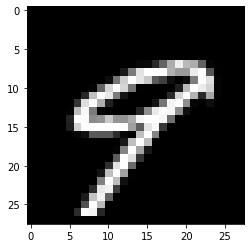

In [4]:
load_path = "200612115604"
weights, nuerons, gradients, details = load_model(load_path)
num = np.random.randint(0, test_images.shape[0], 1)

# application: test a picture
test_img = test_images[num].astype(np.float64)
test_img = test_img.reshape(1,1,28,28)

test_img_pred = softmax(forward(test_img))
test_img_pred = np.argmax(test_img_pred, axis=1)

plt.imshow(test_img[0][0], cmap='gray')
print("\nPrediction of this picture is:", test_img_pred[0])
